# Ensamble of Models

Per valutare le performance del task di conversione in FOL, è stato scelto di costruire un task ad hoc in cui è stato utilizzato un ensemble di tre modelli, in particolare:

1. Meta meta-llama/Llama-3.1-8B-Instruct
2. Alibaba Cloud Qwen/Qwen2.5-7B-Instruct
3. Mistral mistralai/Mistral-7B-Instruct-v0.3

Si è previsto due tipi di ensamble, in particolare:

![ensamble1](pics_notebook\ensamble_mod_1.jpg)

I modelli giudici dopo aver fornito il loro responso, viene calcolata l’accuracy per ogni singolo
giudice e ne viene fatta la media.

![ensamble2](pics_notebook\ensamble_mod_2.jpg)

Nella quale, si differenzia dalla prima dopo aver calcolato i rispettivi output, si procede a
selezionare l’output maggioritario, e si valuta l’accuracy su quest’ultima nuova aggregazione.

In [2]:
#####################################
# IMPORTING LIBRERIE
#####################################
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import string

In [3]:
DATASET_gemma = "stefra/gemma_judge_final"
DATASET_llama = "stefra/llama_judge_final"
DATASET_qwen = "stefra/qwen_judge_final"
dataset_g = load_dataset(DATASET_gemma, split="train").to_pandas()
dataset_l = load_dataset(DATASET_llama, split="train").to_pandas()
dataset_q = load_dataset(DATASET_qwen, split="train").to_pandas()

README.md:   0%|          | 0.00/457 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/171k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/457 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/173k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/457 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/175k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
print(dataset_g['judge_mistral'].value_counts())
print("_"*40)
print(dataset_l['judge_mistral'].value_counts())
print("_"*40)
print(dataset_q['judge_mistral'].value_counts())

judge_mistral
Yes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          941
No                                                                                                                                                                                                                                                                                                                                                                                       

In [5]:
##########################
#Funzione che viene usata per processare la colonna 'judge_mistral', in quanto
# contiene valori che non sono coerenti con gli altri, ossia oltre alla risposta Yes/No,
# contiene una piccola explanation.
#########################
def process_mistral(value):
    stripped_value = value.strip()
    stripped_value = stripped_value.translate(str.maketrans('', '', string.punctuation))
    
    split_value = stripped_value.split()
    
    if stripped_value in ['Yes', 'No']:
        return stripped_value
    else:
        return split_value[0] if split_value else stripped_value

dataset_g['judge_mistral'] = dataset_g['judge_mistral'].apply(process_mistral)
dataset_l['judge_mistral'] = dataset_l['judge_mistral'].apply(process_mistral)
dataset_q['judge_mistral'] = dataset_q['judge_mistral'].apply(process_mistral)

In [6]:
print(dataset_g['judge_mistral'].value_counts())
print("_"*40)
print(dataset_l['judge_mistral'].value_counts())
print("_"*40)
print(dataset_q['judge_mistral'].value_counts())

judge_mistral
Yes    950
No      50
Name: count, dtype: int64
________________________________________
judge_mistral
Yes    967
No      33
Name: count, dtype: int64
________________________________________
judge_mistral
Yes    988
No      12
Name: count, dtype: int64


In [7]:
#####################################
# FUNZIONI DI PLOT
#####################################
def plot_comparison_graph(dataset, columns, labels=['Yes', 'No'], figsize=(10, 6), bar_width=0.25, title="title", ax=None):
    counts = {col: dataset[col].value_counts() for col in columns}
    totals = {col: counts[col].sum() for col in columns}
    percents = {col: {label: counts[col].get(label, 0) / totals[col] * 100 for label in labels} for col in columns}
    
    values = {col: [counts[col].get('Yes', 0), counts[col].get('No', 0)] for col in columns}

    plt.style.use('seaborn-v0_8-muted')

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    x = range(len(labels))

    colors = ['#66C2A5', '#FC8D62', '#8DA0CB']  # Colori per judge_llama, judge_qwen, judge_mistral
    bars = {}
    
    for i, col in enumerate(columns):
        bars[col] = ax.bar(
            [p + i * bar_width for p in x], 
            values[col], 
            width=bar_width, 
            label=col, 
            color=colors[i % len(colors)], 
            align='center', 
            zorder=3
        )

        for bar, label in zip(bars[col], labels):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
                    f'{percents[col][label]:.1f}%', ha='center', va='bottom', fontsize=12, 
                    fontweight='bold', color='black', zorder=4)
    
    ax.set_xlabel('Answer', fontsize=14, fontweight='bold', color='#4C4C4C')
    ax.set_ylabel('Counts', fontsize=14, fontweight='bold', color='#4C4C4C')
    ax.set_title( title,fontsize=16, fontweight='bold', color='#2F4F4F')

    ax.set_xticks([p + bar_width for p in x])
    ax.set_xticklabels(labels, fontsize=12, color='#4C4C4C')

    ax.legend(title="Answer From", title_fontsize=12, fontsize=12, loc='upper right')

    ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

    if ax is None:
        plt.tight_layout()

def plot_ensemble_graph(dataset, columns, new_column_name='judge_ensemble', labels=['Yes', 'No'], figsize=(8, 6), bar_width=0.35, title="title", ax=None):
    
    def ensemble(row):
        # Funzione per simulare un ensemble
        tot_yes = 0
        for col in columns:
            if row[col].lower() == 'yes':
                tot_yes += 1
        if tot_yes > 1:  # Etichetta maggioritaria
            return 'Yes'
        else:
            return 'No'

    dataset[new_column_name] = dataset.apply(ensemble, axis=1)
    ensemble_counts = dataset[new_column_name].value_counts()

    ensemble_total = ensemble_counts.sum()
    ensemble_percent = {
        "Yes": ensemble_counts.get('Yes', 0) / ensemble_total * 100,
        "No": ensemble_counts.get('No', 0) / ensemble_total * 100
    }

    ensemble_values = ensemble_counts.get('Yes', 0), ensemble_counts.get('No', 0)
    x = range(len(labels))

    plt.style.use('seaborn-v0_8-muted')

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ensemble_bars_yes = ax.bar(x[0], ensemble_values[0], width=bar_width, label='Yes', color='#66C2A5', align='center', zorder=3)
    ensemble_bars_no = ax.bar(x[1] + bar_width, ensemble_values[1], width=bar_width, label='No', color='#FC8D62', align='center', zorder=3)

    for bar, label, percent in zip(ensemble_bars_yes, labels, [ensemble_percent['Yes']]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
                f'{percent:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black', zorder=4)

    for bar, label, percent in zip(ensemble_bars_no, labels, [ensemble_percent['No']]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
                f'{percent:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black', zorder=4)

    ax.set_xlabel('Answer', fontsize=14, fontweight='bold', color='#4C4C4C')
    ax.set_ylabel('Count', fontsize=14, fontweight='bold', color='#4C4C4C')
    ax.set_title(title, fontsize=16, fontweight='bold', color='#2F4F4F')
    ax.set_xticks([p + bar_width / 2 for p in x])
    ax.set_xticklabels(labels, fontsize=12, color='#4C4C4C')
    ax.legend(title="Types", title_fontsize=12, fontsize=12, loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

    if ax is None:
        plt.tight_layout()

# Funzione per plottare tutti i grafici
def plot_all_graphs(datasets, columns_list, titles_list):
    fig, axs = plt.subplots(3, 2, figsize=(14, 18))  # 3 righe, 2 colonne

    for i, dataset in enumerate(datasets):
        columns = columns_list[i]
        title = titles_list[i]

        plot_comparison_graph(dataset, columns, ax=axs[i, 0], title=f"Comparison {title}")
        plot_ensemble_graph(dataset, columns, ax=axs[i, 1], title=f"Ensemble {title}")
    
    plt.tight_layout()
    plt.show()

In [8]:
# Funzione per calcolare l'accuratezza come frazione di "Yes" sul totale, molto elementare
def calculate_accuracy_as_yes_fraction(dataset, judge_column):
    yes_count = dataset[judge_column].value_counts().get('Yes', 0)  # Conta il numero di "Yes"
    total_count = len(dataset)
    accuracy = yes_count / total_count
    return accuracy

# Gemma 2 2B it

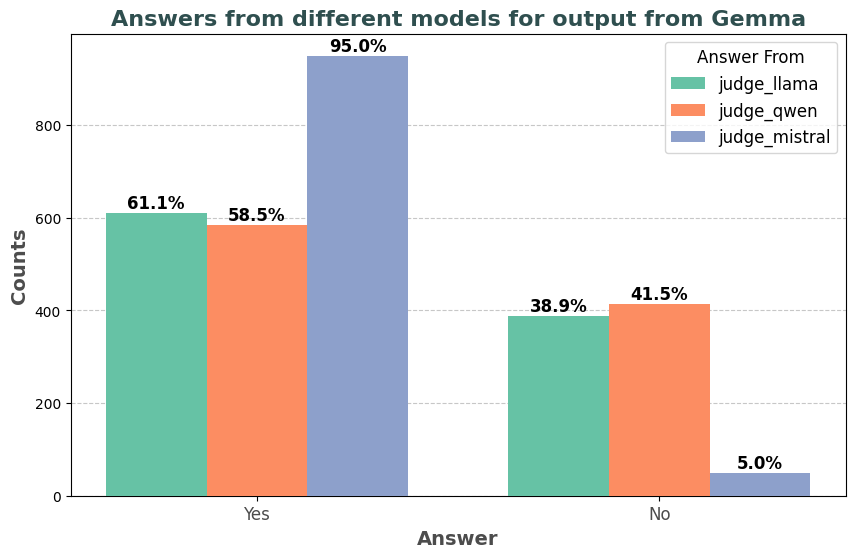

In [9]:
plot_comparison_graph(dataset_g, columns=['judge_llama', 'judge_qwen', 'judge_mistral'],title="Answers from different models for output from Gemma")

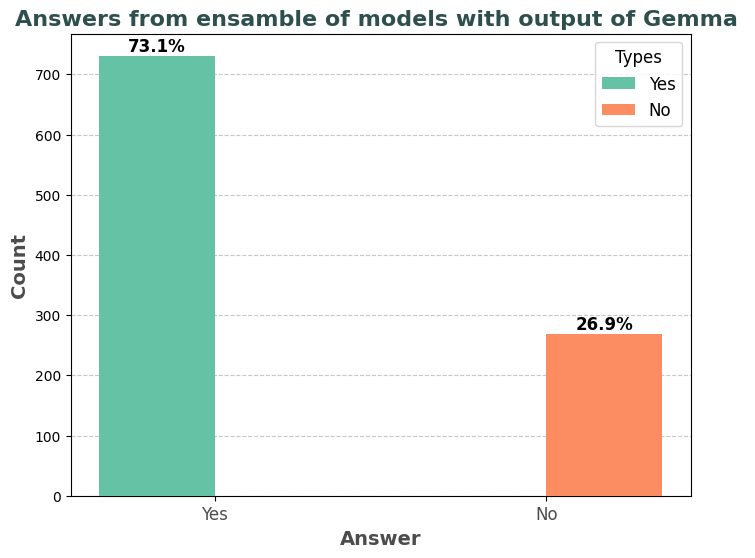

In [10]:
plot_ensemble_graph(dataset_g, columns=['judge_llama', 'judge_qwen', 'judge_mistral'],title="Answers from ensamble of models with output of Gemma ")

In [11]:
judges = ['judge_llama', 'judge_qwen', 'judge_mistral']
accuracies = {judge: calculate_accuracy_as_yes_fraction(dataset_g, judge) for judge in judges}

average_accuracy = sum(accuracies.values()) / len(accuracies)

print("Accuratezze per ogni giudice (frazione di 'Yes'):")
for judge, accuracy in accuracies.items():
    print(f"{judge}: {accuracy * 100:.2f}%")

print(f"\nAccuratezza media: {average_accuracy * 100:.2f}%")

Accuratezze per ogni giudice (frazione di 'Yes'):
judge_llama: 61.10%
judge_qwen: 58.50%
judge_mistral: 95.00%

Accuratezza media: 71.53%


# Llama 3.2 3B it

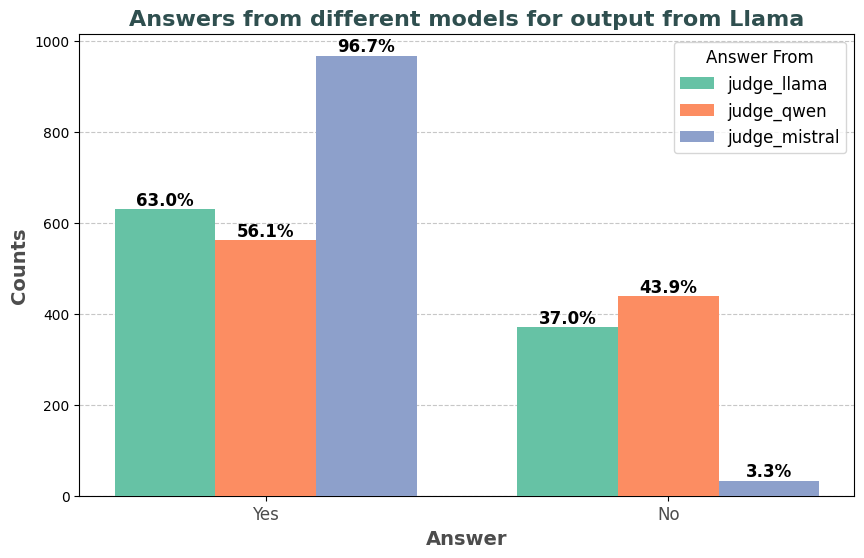

In [12]:
plot_comparison_graph(dataset_l, columns=['judge_llama', 'judge_qwen', 'judge_mistral'],title="Answers from different models for output from Llama")

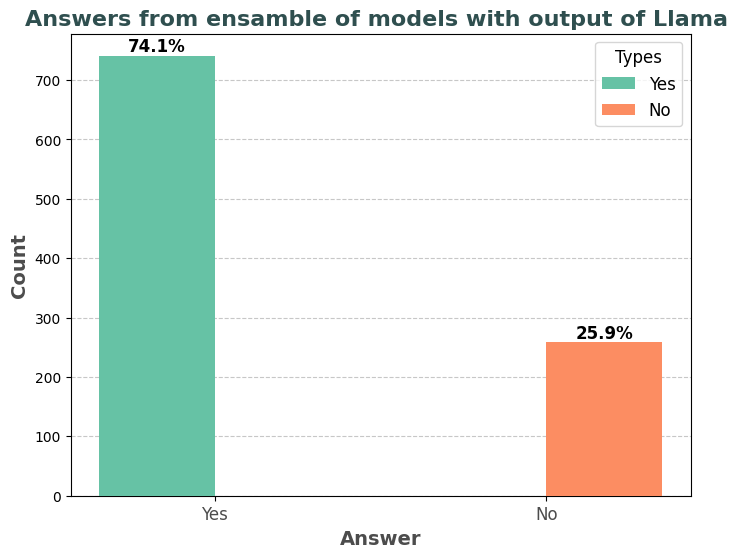

In [13]:
plot_ensemble_graph(dataset_l, columns=['judge_llama', 'judge_qwen', 'judge_mistral'],title="Answers from ensamble of models with output of Llama ")

In [14]:
judges = ['judge_llama', 'judge_qwen', 'judge_mistral']
accuracies = {judge: calculate_accuracy_as_yes_fraction(dataset_l, judge) for judge in judges}

average_accuracy = sum(accuracies.values()) / len(accuracies)

print("Accuratezze per ogni giudice (frazione di 'Yes'):")
for judge, accuracy in accuracies.items():
    print(f"{judge}: {accuracy * 100:.2f}%")

print(f"\nAccuratezza media: {average_accuracy * 100:.2f}%")

Accuratezze per ogni giudice (frazione di 'Yes'):
judge_llama: 63.00%
judge_qwen: 56.10%
judge_mistral: 96.70%

Accuratezza media: 71.93%


# Qwen3 4b it

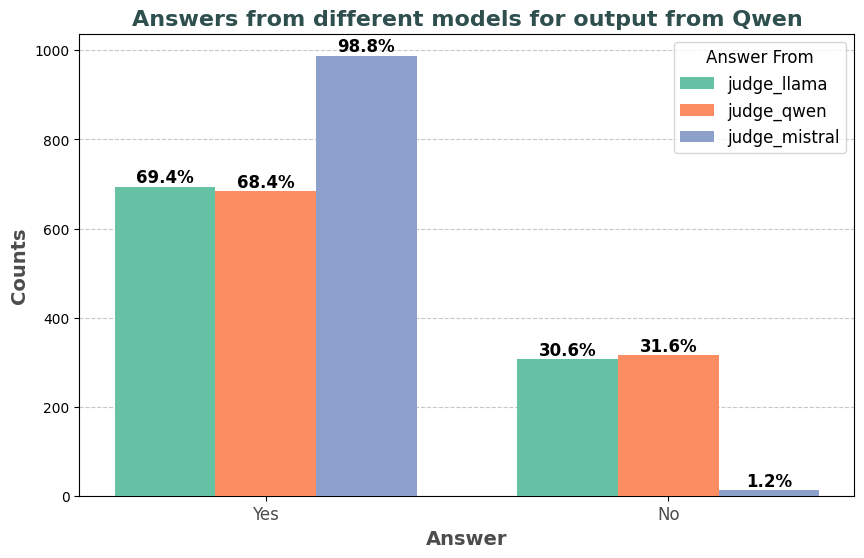

In [15]:
plot_comparison_graph(dataset_q, columns=['judge_llama', 'judge_qwen', 'judge_mistral'],title="Answers from different models for output from Qwen")

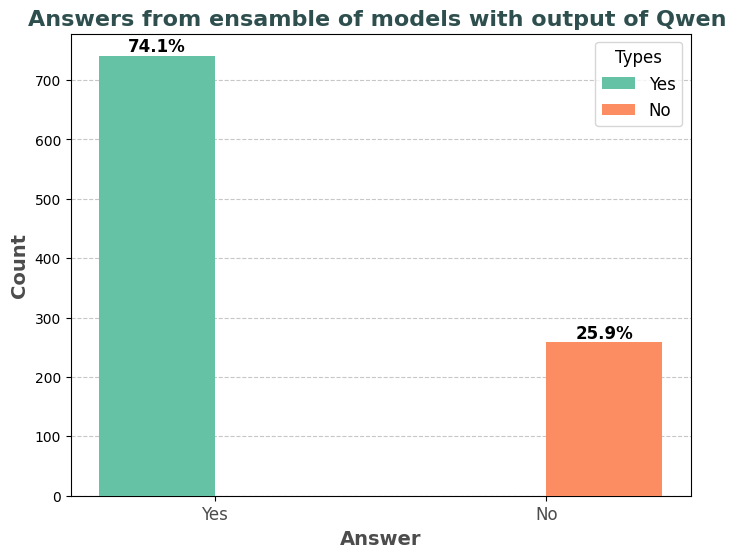

In [16]:
plot_ensemble_graph(dataset_l, columns=['judge_llama', 'judge_qwen', 'judge_mistral'],title="Answers from ensamble of models with output of Qwen ")

In [17]:
judges = ['judge_llama', 'judge_qwen', 'judge_mistral']
accuracies = {judge: calculate_accuracy_as_yes_fraction(dataset_q, judge) for judge in judges}

average_accuracy = sum(accuracies.values()) / len(accuracies)

print("Accuratezze per ogni giudice (frazione di 'Yes'):")
for judge, accuracy in accuracies.items():
    print(f"{judge}: {accuracy * 100:.2f}%")

print(f"\nAccuratezza media: {average_accuracy * 100:.2f}%")

Accuratezze per ogni giudice (frazione di 'Yes'):
judge_llama: 69.40%
judge_qwen: 68.40%
judge_mistral: 98.80%

Accuratezza media: 78.87%


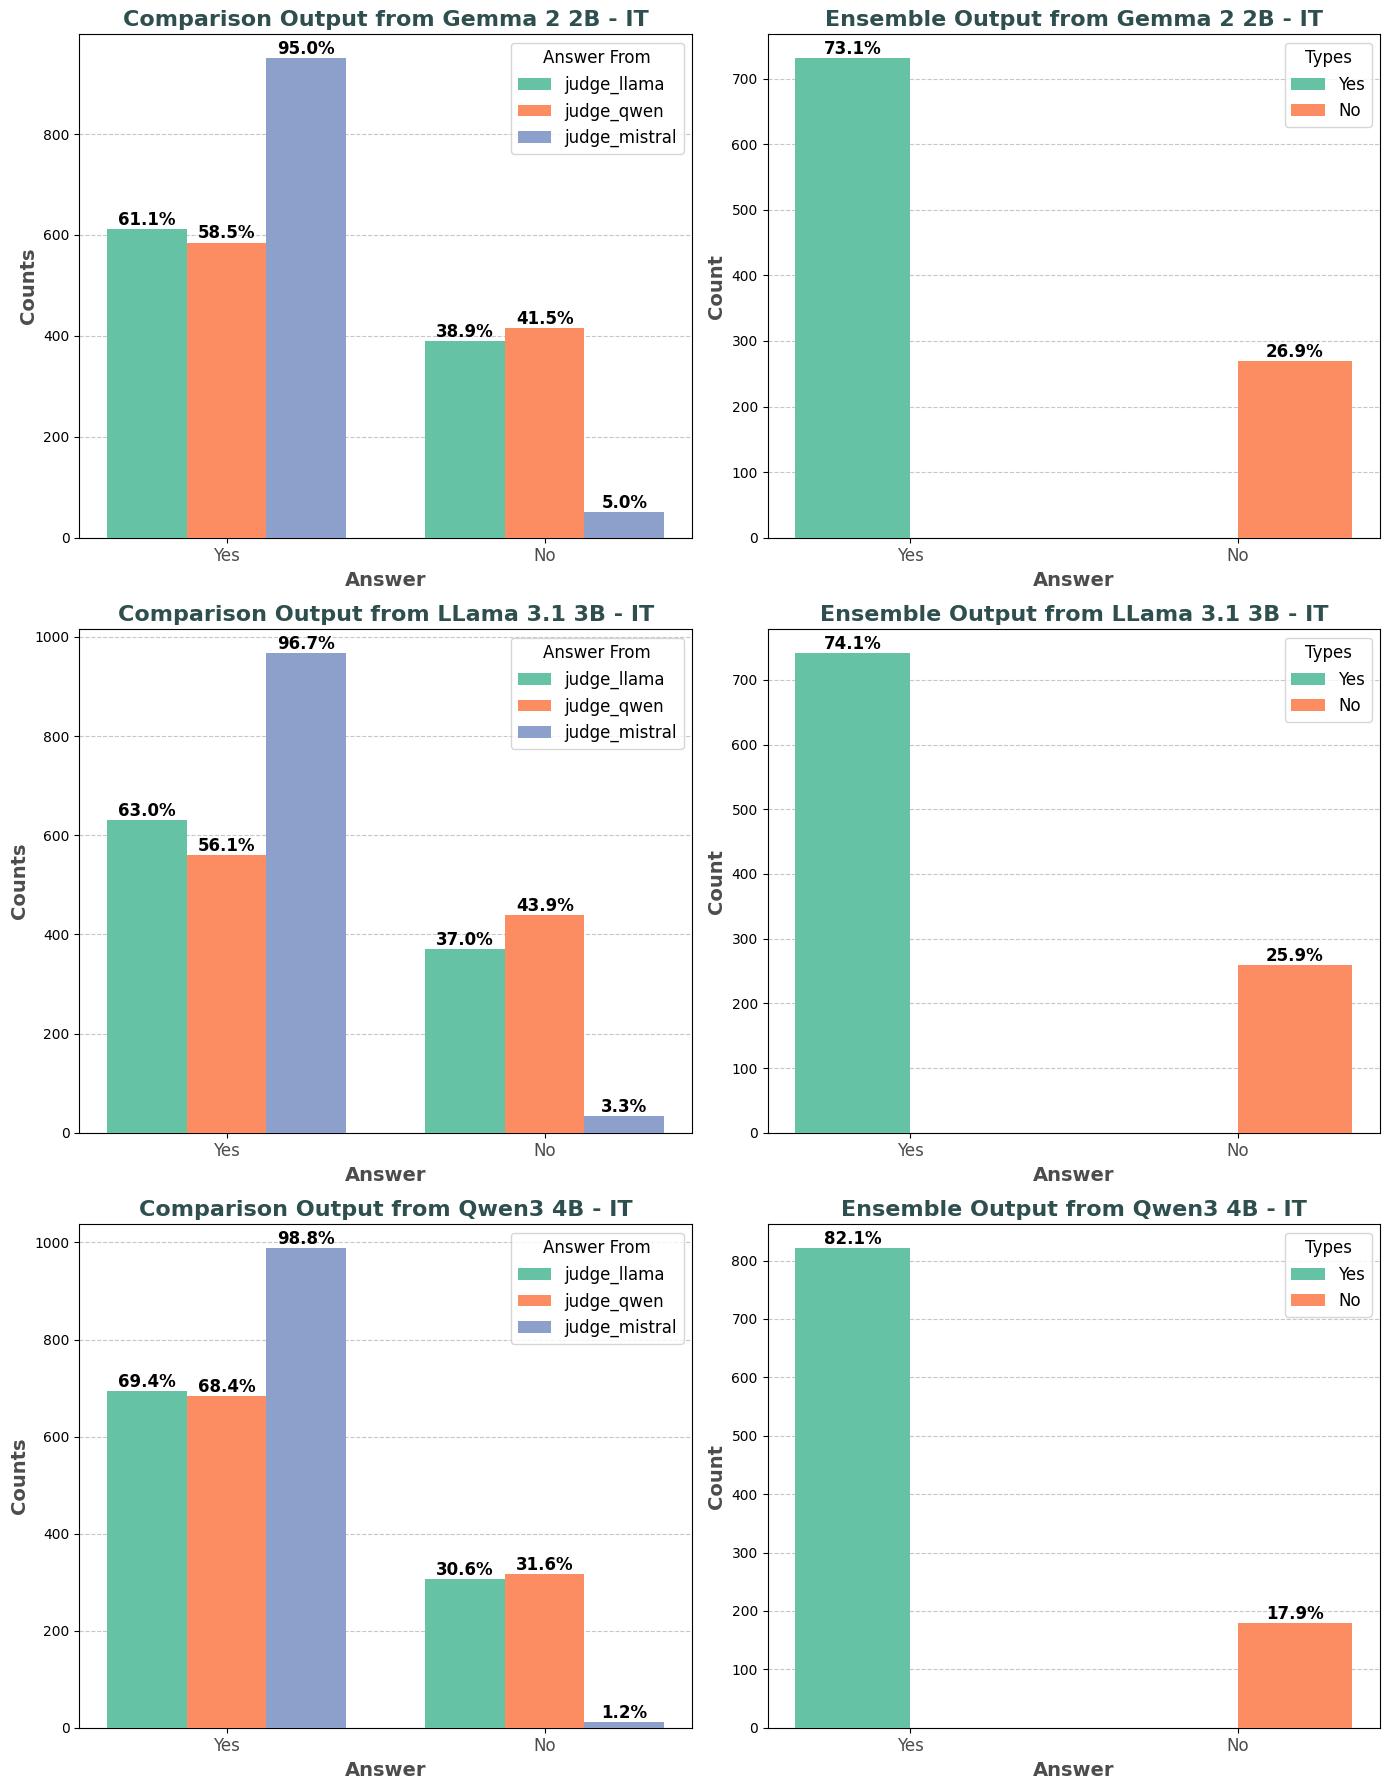

In [18]:
datasets = [dataset_g, dataset_l, dataset_q]
columns_list = [['judge_llama',"judge_qwen",'judge_mistral'], ['judge_llama',"judge_qwen",'judge_mistral'], ['judge_llama',"judge_qwen",'judge_mistral']]  # Colonne da confrontare per ciascun dataset
titles_list = ['Output from Gemma 2 2B - IT', 'Output from LLama 3.1 3B - IT', 'Output from Qwen3 4B - IT']

plot_all_graphs(datasets, columns_list, titles_list)